In [8]:
import cv2
import pandas as pd
import torch
from torch.utils.data import DataLoader
import numpy as np

from train import TTDataset, Network, HIDDEN_DIM, OUTPUT_DIM, IS_BID, NUM_LAYERS
from shot_extractor.pose_extractor import shotsExtractor
from utils.general import read_raw_data
from utils.learn import predict

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print('device', device)

NUM_FEATURES = 100
model = Network(NUM_FEATURES, HIDDEN_DIM, OUTPUT_DIM,
                bidirectional=IS_BID, num_layers=NUM_LAYERS,
                use_attention=True, device=device).to(device)

model.load_state_dict(torch.load('model_results/fco_best.pt'))
model.eval()

print('Model loaded to memory')
print(model)

device cuda
Model loaded to memory
Network(
  (dropout): Dropout(p=0.5, inplace=False)
  (atten): Attention()
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)


In [9]:
pos = shotsExtractor(mv_wd=3, mv_th=0.6, shots_delta=3,
                     min_length=6, file_name='fco_rt', e2e=True)

single_pose_data = ['x', 'y', 'z', 'vis']
pose_columns = []
for i in range(0, shotsExtractor.pose_max_idx + 1):
    pose_columns.extend(['{}_{}'.format(i, key) for key in single_pose_data])

data_df = pd.DataFrame(columns=pose_columns)
score_df = pd.DataFrame(columns=['score', 'shot', 'frames'])

vid = cv2.VideoCapture(0)

while True:
    success, img = vid.read()
    if not success:
        break
    pos.process(img)

    cv2.imshow('Vid', img)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
vid.release()
cv2.destroyAllWindows()

pos.save_shots_labeled_csv(score_df, data_df)
score_df.index.name = 'name'
x, y_none, metadata = read_raw_data(score_df, data_df, e2e=True)
labels = pd.DataFrame({'label': y_none, 'metadata': metadata})

amount = len(metadata)
print(f'{amount} shots extracted...')

test_data = TTDataset(x, labels)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

_, _, y_pred, _, confs = predict(model, test_loader, device, 1, 0.93)

for i, (p, c) in enumerate(zip(y_pred, confs)):
    print(f'idx: {i} pred: {p} conf: {c}')

8it [00:00, 3994.58it/s]

8 shots extracted...
low conf:  0.8651858568191528
low conf:  0.8039023876190186
low conf:  0.612892210483551
low conf:  0.813866376876831
idx: 0 pred: 0 conf: 0.9979593753814697
idx: 1 pred: 0 conf: 0.8651858568191528
idx: 2 pred: 0 conf: 0.5309395790100098
idx: 3 pred: 0 conf: 0.8039023876190186
idx: 4 pred: 0 conf: 0.612892210483551
idx: 5 pred: 0 conf: 0.813866376876831
idx: 6 pred: 1 conf: 0.9650993347167969
idx: 7 pred: 0 conf: 0.994631290435791


finished saving gif: fco_rt_2


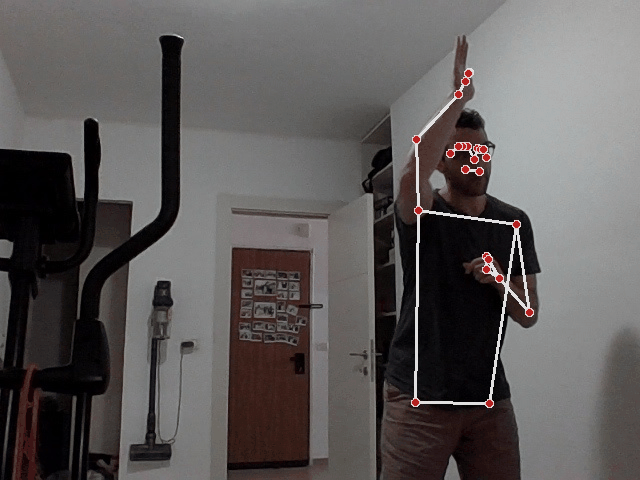

In [12]:
import numpy as np
from visualization import points_visualization
from IPython.display import Image

y_pred = np.array(y_pred)
debug_idx = 2
shot_name = labels.iloc[debug_idx]['metadata']['name']
amount = labels.iloc[debug_idx]['metadata']['frames']


vid_path = 'fco/fco_rt'
gif_name = f'real_{shot_name}'
points_visualization.create_vid_gif(vid_path, shot_name, amount)
with open(f'visualization/shots_3d_demo/{gif_name}.gif','rb') as f:
    display(Image(data=f.read(), format='png', width=350, height=450))
